In [ ]:
import numpy as np
import math, copy, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")


from tensorflow import keras
from tensorflow.keras import layers


Source: https://nlp.seas.harvard.edu/2018/04/03/attention.html

Making attention network


1.   Encoder
2.   Decoder



In [ ]:
class EncoderDecoder(layers.Layer):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        """
        memory is output from encoder
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(layers.Layer):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = layers.Dense(vocab, activation = 'linear')

    def forward(self, x):
        return tf.layers.log_softmax(self.proj(x), dim=-1)

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return [copy.deepcopy(module) for _ in range(N)]

In [ ]:
class LayerNorm(layers.Layer):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = tf.ones(features)
        self.b_2 = tf.zeros(features)
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class Encoder(layers.Layer):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [ ]:
class SublayerConnection(layers.Layer):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = layers.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderLayer(layers.Layer):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

Decoder take output of encoder as memory. masked input as query.


In [ ]:
class Decoder(layers.Layer):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class DecoderLayer(layers.Layer):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return tf.convert_to_tensor(subsequent_mask) == 0

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = tf.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = tf.nn.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return tf.matmul(p_attn, value), p_attn

Implementation of Multi heads
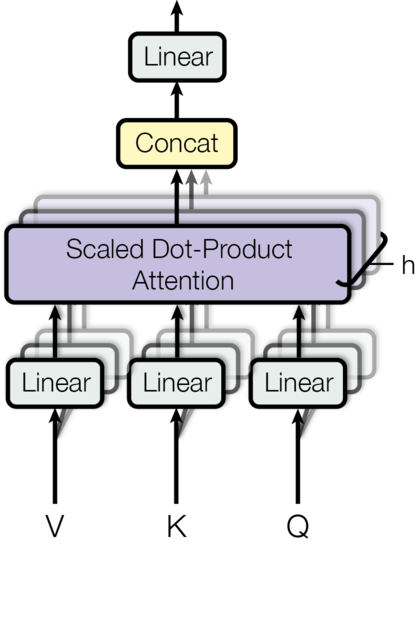

In [ ]:
class MultiHeadedAttention(layers.Layer):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(layers.Dense(d_model), 4)
        self.attn = None
        self.dropout = layers.Dropout(rate=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [tf.transpose(tf.reshape(l(x), [nbatches, -1, self.h, self.d_k]), perm = [0,2,1])
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a reshape operation and apply a final linear.
        x = tf.reshape(tf.identity(tf.transpose(x, perm = [0,2,1])), [nbatches, -1, self.h * self.d_k])
        return self.linears[-1](x)


In [ ]:
class PositionwiseFeedForward(layers.Layer):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = layers.Dense(d_ff, activation='linear')
        self.w_2 = layers.Dense(d_model, activation='linear')
        self.dropout = layers.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(tf.nn.relu(self.w_1(x))))

In [ ]:
class Embeddings(layers.Layer):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = layers.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(layers.Layer):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = layers.Dropout(dropout)
        
        # Compute the positional encodings once in log space.
        # pe = tf.zeros([max_len, d_model])
        position = tf.expand_dims(tf.range(0, max_len, dtype=tf.float32), 1)
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(math.log(10000.0) / d_model))
        # pe[:, 0::2] = tf.math.sin(position * div_term)
        # pe[:, 1::2] = tf.math.cos(position * div_term)
        self.pe = tf.concat([tf.math.sin(position * div_term), tf.math.cos(position * div_term)], 1)
        self.pe = tf.expand_dims(self.pe, 0)
        # self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]]  # add embeded input with positional encode
        return self.dropout(x)

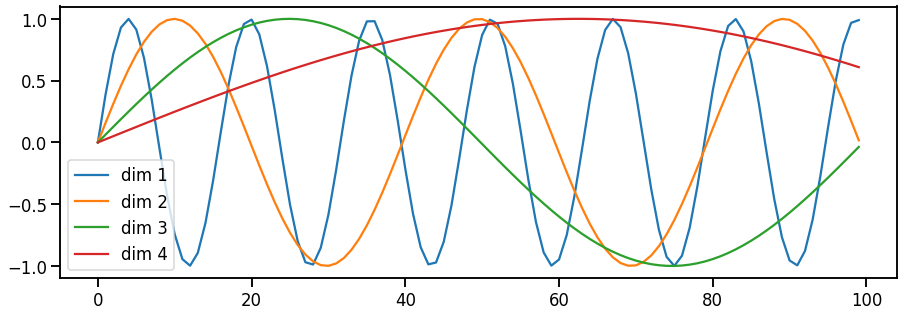

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(tf.zeros([1, 100, 20]))
plt.plot(np.arange(100), y[0, :, 1:5].numpy())
plt.legend(["dim %d"%p for p in [1,2,3,4]])
None

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        keras.Sequential(Embeddings(d_model, src_vocab), c(position)),
        keras.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    # for p in model.parameters():
    #     if p.dim() > 1:
    #         keras.initializers.GlorotUniform(p)
    return model

In [ ]:
tmp_model = make_model(10, 10, 2)